In [1]:
# These packages enable reloading a module
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import emg.data as data
import model.model as model
import emg.display as display
import model.knowledgeBase as kb

from sklearn.linear_model import LinearRegression

In [4]:
metadata = data.read_meta_file('data/P1/P1_AllLifts.mat')
session_data = data.read_session('data/P1/HS_P1_S1.mat')

In [5]:
markers = None
experiment = kb.create_emg_eeg_kb(meta=metadata, sessions=[session_data], markers=markers)

model/knowledgeBase.py:560: UserWarning: WARNING - EEG data does not contain enough data points. Has 119496 data points but 119496 are required. Skipped Lift 33
  warnings.warn(warning)


In [6]:
print experiment.recursive_to_string()

Experiment: 1 Setups, 1 Sessions, 0 Subjects
Subjects:
Setups:
	Setup setup0: 3 Modalities
		Modality emg: 5 Samples, 4000 Hz
			Sample: First Dorsal Interosseus
			Sample: Brachoradial
			Sample: Anterior Deltoid
			Sample: Flexor Digitorum
			Sample: Common Extensor Digitorum
		
		Modality eeg: 32 Samples, 500 Hz
			Sample: P3
			Sample: Pz
			Sample: O2
			Sample: O1
			Sample: P7
			Sample: P4
			Sample: T8
			Sample: Fz
			Sample: C3
			Sample: TP9
			Sample: C4
			Sample: FC1
			Sample: FC2
			Sample: FC5
			Sample: FC6
			Sample: PO9
			Sample: T7
			Sample: P8
			Sample: PO10
			Sample: Fp1
			Sample: Oz
			Sample: Fp2
			Sample: F3
			Sample: F4
			Sample: F7
			Sample: F8
			Sample: TP10
			Sample: Cz
			Sample: CP1
			Sample: CP2
			Sample: CP5
			Sample: CP6
		
		Modality kin: 12 Samples, 500 Hz
			Sample: Px4 - position x sensor 4
			Sample: Py3 - position y sensor 3
			Sample: Py1 - position y sensor 1
			Sample: Pz4 - position z sensor 4
			Sample: Px2 - position x senso

# Prediction

In [46]:
dat = abs(experiment.Sessions['session_1'].Recordings['emg_data'].get_data(pandas=False))
dat.shape

(920507, 5)

In [47]:
experiment.Sessions['session_1'].Recordings['emg_data'].set_data(dat)

In [76]:
kinr = experiment.Sessions['session_1'].Recordings['kin_data']
aligned = data.align_by_mean(experiment.Sessions['session_1'].Recordings['emg_data'],
                             experiment.Sessions['session_1'].Recordings['kin_data'])

In [68]:
cols = ['Px1 - position x sensor 1',
        'Py1 - position y sensor 1',
        'Pz1 - position z sensor 1'
       ]

In [69]:
kinlist = kinr.get_trials_as_list(samples=cols, pandas=False)

In [51]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = data.train_valid_test_from_lists(
    [aligned], kinlist
    )

In [52]:
m = LinearRegression()
m.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
Y = m.predict(train_X)
VY = m.predict(val_X)
TY = m.predict(test_X)

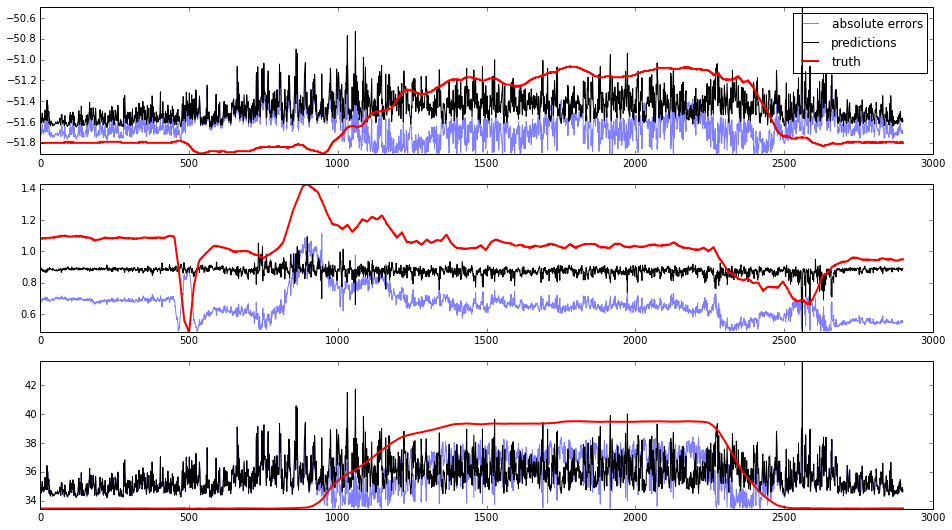

In [54]:
start, stop = 100, 3000
display.predict_report(train_X[start:stop], Y[start:stop], train_Y[start:stop])

In [116]:
wdata, wtargets = data.windowify_labeled_data_set(
    aligned,
    kinr.get_trials_as_list(samples=cols, pandas=False),
    length=1000, 
    offset=1
    )

In [117]:
wdata = data.padzeros(wdata, front=False)
wtargets = data.padzeros(wtargets, front=False)

In [109]:
wdata[0].shape

(200, 5)

In [110]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = data.sets_for_sequence_learning(wdata, wtargets)

In [111]:
train_X.shape

(551, 1000)

In [112]:
m = LinearRegression()
m.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [113]:
Y = m.predict(train_X)
VY = m.predict(val_X)
TY = m.predict(test_X)

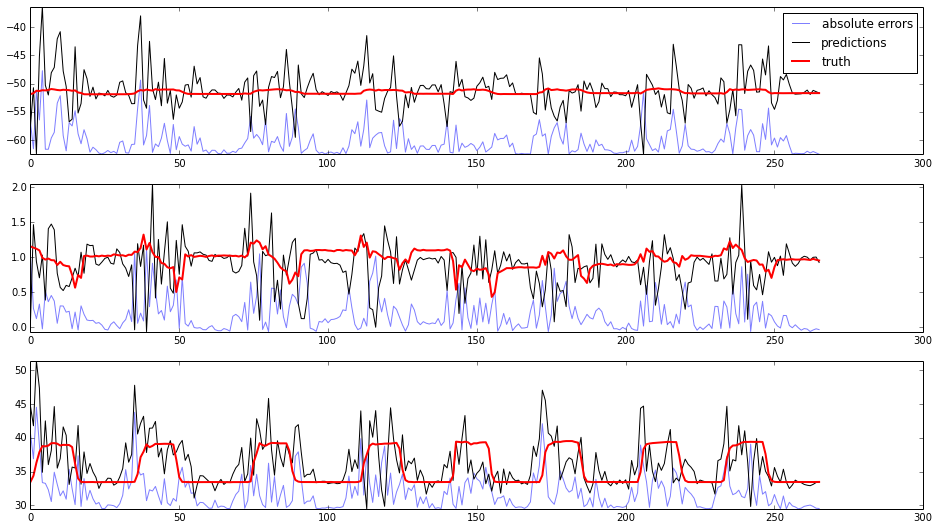

In [114]:
start, stop = 10, 6000
display.predict_report(test_X[start:stop], TY[start:stop], test_Y[start:stop])

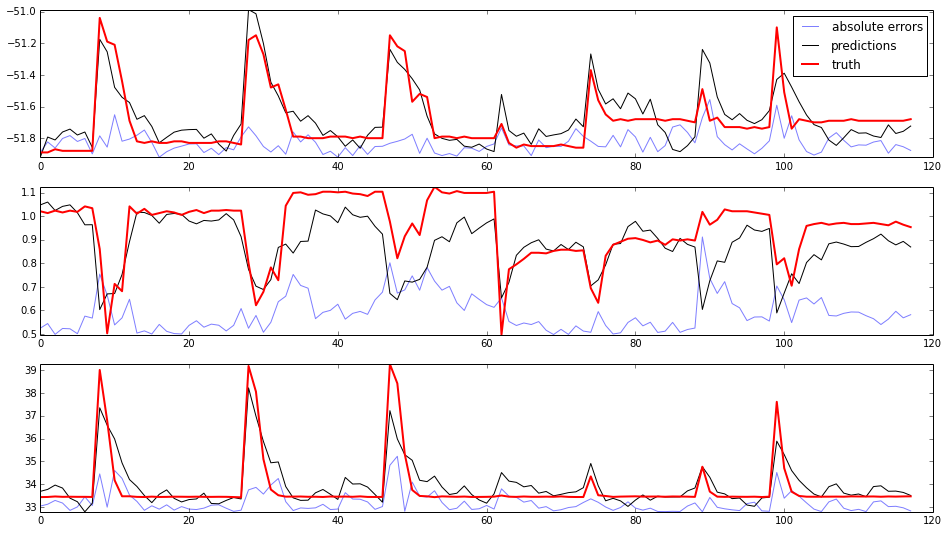

In [106]:
start, stop = 10, 6000
display.predict_report(test_X[start:stop], TY[start:stop], test_Y[start:stop])

# Classification